# Regional Preference and Genre Specialization

## Tujuan
Menganalisis perbedaan preferensi pasar video game lintas region melalui:
- Komposisi penjualan regional
- Dominasi genre per region
- Spesialisasi pasar dan indikasi homogenisasi global

Catatan metodologi

Analisis berbasis share regional dan agregasi genre. Tidak menggunakan tren tahunan karena data bersifat kumulatif.

## Load Data

In [3]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

cwd = Path.cwd()
if (cwd / 'data').is_dir():
    data_path = cwd / 'data' / 'processed' / 'vgsales_cleaned.csv'
else:
    data_path = cwd.parent / 'data' / 'processed' / 'vgsales_cleaned.csv'

df = pd.read_csv(data_path)
df["Year"] = pd.to_numeric(df["Year"], errors="coerce").round().astype("Int64")
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Total_Sales,Share_NA,Share_EU,Share_JP,decade_cohort
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,82.74,0.501450,0.350737,0.045564,2000.0
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,40.24,0.722664,0.088966,0.169235,1980.0
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,35.83,0.442367,0.359475,0.105777,2000.0
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,33.00,0.477273,0.333636,0.099394,2000.0
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,31.38,0.359146,0.283301,0.325685,1990.0


Dataset sudah mengandung total sales dan share regional. Analisis difokuskan pada proporsi, bukan nilai absolut.

### Komposisi penjualan global per region
Langkah awal untuk melihat struktur pasar global.

In [4]:
region_totals = df[["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]].sum()
region_share = region_totals / region_totals.sum()
region_share


NA_Sales       0.492712
EU_Sales       0.273012
JP_Sales       0.144801
Other_Sales    0.089475
dtype: float64

Distribusi ini menjadi baseline. Analisis berikutnya membandingkan apakah genre dan region menyimpang dari struktur global ini.

### Agregasi genre per region
Mengukur kontribusi penjualan genre di tiap region.

In [5]:
genre_region = (
    df.groupby("Genre")
      .agg(
          NA=("NA_Sales", "sum"),
          EU=("EU_Sales", "sum"),
          JP=("JP_Sales", "sum"),
          Other=("Other_Sales", "sum")
      )
)

genre_region.head()


,NA,EU,JP,Other
Genre,,,,
Action,877.83,525.00,159.95,187.38
Adventure,105.80,64.13,52.07,16.81
Fighting,223.59,101.32,87.35,36.68
Misc,410.24,215.98,107.76,75.32
Platform,447.05,201.63,130.77,51.59


### Normalisasi menjadi share regional
Tujuan: membandingkan preferensi tanpa bias ukuran pasar.

In [6]:
genre_region_share = genre_region.div(genre_region.sum(axis=0), axis=1)
genre_region_share.head()


,NA,EU,JP,Other
Genre,,,,
Action,0.199827,0.215683,0.123894,0.234886
Adventure,0.024084,0.026346,0.040332,0.021072
Fighting,0.050897,0.041625,0.067660,0.045979
Misc,0.093386,0.088730,0.083469,0.094416
Platform,0.101765,0.082835,0.101292,0.064669


Nilai menunjukkan proporsi kontribusi genre terhadap total penjualan di masing-masing region.

### Visual spesialisasi genre per region
Heatmap dipakai untuk membaca perbedaan preferensi secara cepat.

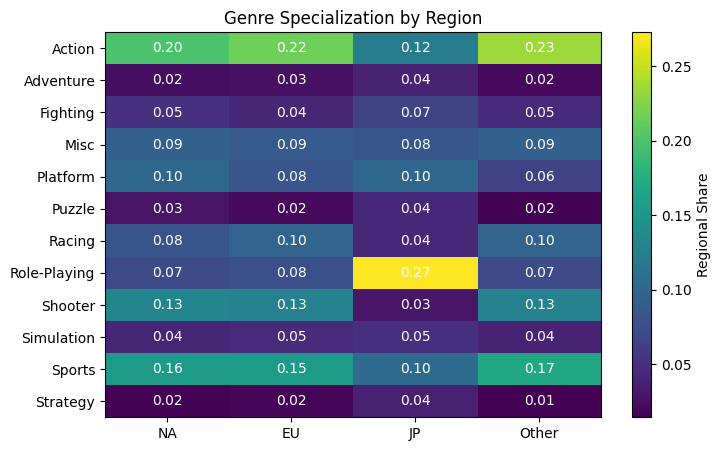

In [8]:
plt.figure(figsize=(8, 5))
plt.imshow(genre_region_share.values, aspect="auto")
plt.xticks(range(len(genre_region_share.columns)), genre_region_share.columns)
plt.yticks(range(len(genre_region_share.index)), genre_region_share.index)
plt.colorbar(label="Regional Share")
plt.title("Genre Specialization by Region")

# tambahkan angka di tiap sel
for i in range(genre_region_share.shape[0]):
    for j in range(genre_region_share.shape[1]):
        plt.text(
            j, i,
            f"{genre_region_share.iloc[i, j]:.2f}",
            ha="center", va="center", color="white"
        )

plt.show()


Kontras warna menunjukkan genre yang kuat di region tertentu. Pola ekstrem menunjukkan pasar terspesialisasi, pola seragam menunjukkan homogenisasi.

### Dominasi genre per region
Mengidentifikasi genre dengan kontribusi terbesar di tiap region.

In [9]:
top_genre_by_region = genre_region_share.idxmax()
top_genre_by_region


NA             Action
EU             Action
JP       Role-Playing
Other          Action
dtype: object

Hasil ini merangkum preferensi dominan pasar. Perbedaan tajam antar region mengindikasikan segmentasi yang kuat.

### Perbandingan dengan struktur global
Mengukur apakah preferensi regional menyimpang dari komposisi global.

In [10]:
global_genre_share = genre_region.sum(axis=1) / genre_region.sum().sum()
comparison = genre_region_share.sub(global_genre_share, axis=0)
comparison.head()


,NA,EU,JP,Other
Genre,,,,
Action,0.003529,0.019385,-0.072403,0.038588
Adventure,-0.002701,-0.000439,0.013548,-0.005713
Fighting,0.000544,-0.008728,0.017307,-0.004374
Misc,0.002615,-0.002041,-0.007302,0.003645
Platform,0.008556,-0.010375,0.008083,-0.028540


Nilai positif menunjukkan genre overrepresented di region tertentu dibanding struktur global. Nilai negatif menunjukkan underrepresentation.

**Insight**
- Struktur pasar global tidak tercermin identik di tiap region.
- Beberapa genre menunjukkan spesialisasi regional yang kuat.
- Preferensi pasar tidak sepenuhnya homogen, meski berbagi pola global.